<a href="https://colab.research.google.com/github/SAIKARTHIGEYAN1512/review2/blob/main/hyper41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/content/chest_xray/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 224
TRAINING_DIR = "/content/chest_xray/chest_xray/train"
training_datagen = ImageDataGenerator(rescale = 1./255 ,
                                      shear_range=0.2,
                                      zoom_range=0.2)
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(IMG_SIZE,IMG_SIZE) ,class_mode='categorical',
                                                       batch_size=64,shuffle=True )


TEST_DIR = "/content/chest_xray/chest_xray/test"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode = None , batch_size = 64,
                                                  shuffle = False)


VAL_DIR = "/content/chest_xray/chest_xray/val"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE),class_mode='categorical',
                                                       batch_size=64,shuffle= False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


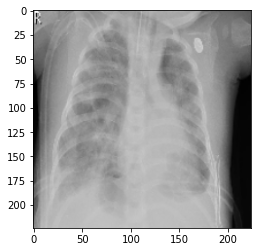

In [ ]:
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
!rm -rf ./logs/

In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','Adadelta','Adagrad']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(train_generator, epochs=1)
  _, accuracy = model.evaluate(val_generator)
  return accuracy

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Adadelta'}
10/10 [==============================] - 7s 588ms/step - loss: 0.5484 - accuracy: 0.6683
--- Starting trial: run-1
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Adagrad'}
10/10 [==============================] - 7s 585ms/step - loss: 5.7514 - accuracy: 0.6250
--- Starting trial: run-2
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
10/10 [==============================] - 7s 578ms/step - loss: 5.7514 - accuracy: 0.6250
--- Starting trial: run-3
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
10/10 [==============================] - 7s 578ms/step - loss: 5.7514 - accuracy: 0.6250
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'Adadelta'}
10/10 [==============================] - 7s 586ms/step - loss: 0.6380 - accuracy: 0.6250
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'Adagrad'}
10/10 [==============================] - 7s 579ms/step -